---
title: Calling Lean Functions Like Python Functions
date: 2026-02-02
---

I think Lean is neat.

Maybe _especially_ as a programming language. Got lots of fun doodads, cool compiler to fast code, metaprogramming, and then some day maybe you can prove something if you feel like it.

I made a python library to make lean-python interop a little less painful https://github.com/philzook58/leancall . Cody has also been sniffing around this area and has been poking me to try and build something like this. https://github.com/codyroux/lean-to-python

I like using python. I defend it to my PL nerd friends and shit on it to my python friends. It has a vast number of useful libraries. It's nice for ripping ideas out.

Once you get past the standard library and mathlib, Lean's library ecosystem is not great yet. Using python as a shim to get pictures and file formats and stuff is not that crazy. Using Lean to write python libraries is also not that crazy of an idea I think. Some projects already do it (https://github.com/leanprover/KLR https://github.com/alerad/leancert )

https://github.com/augustepoiroux/LeanInteract Lean interact is a project that gives you a lean repl as a python library. It's main intent is probably for machine learning proof stuff. This library really supplies the heaviest lifting and what I added was some ergonomics shellac.

I thought it would be fun to use it to build a python lean bridge where you can use lean functions fairly painlessly as python functions.

This is done by basically 3 things:

1. an extensible [singledispatch](https://docs.python.org/3/library/functools.html#functools.singledispatch) `to_lean` to serialize python values to lean
2. a [lark](https://github.com/lark-parser/lark) parser for lean output. I like lark.
3. a grep for `defs`
4. a `LeanFun` class that uses these things to take python values to and from lean

Here's what it looks like to use it.

In [8]:
import leancall as lc

mod = lc.from_string("def foo (x : Nat) (s : String) : String := s ++ toString x")
mod.foo(42, "The answer is ")

'The answer is 42'

# Controlling a Cartpole
It is fast enough to control a gym environment  https://gymnasium.farama.org/introduction/basic_usage/ (gym is a library for reinforcement learning)

Cody had a lean pendulum controller that he kept private for some reason. 


In [1]:
%%file /tmp/cartpole.lean

def action (obs : List Float) : Nat := 
    let pos := obs[0]!
    let vel := obs[1]!
    let ang := obs[2]!
    let ang_vel := obs[3]!
    -- I fiddled with this until it seems to work
    if pos - 1 * vel + 2.0 * ang + 0.7 * ang_vel < 0.0 then
        0
    else
        1

Overwriting /tmp/cartpole.lean


In [2]:
import leancall as lc
import leancall.numpy
mod = lc.from_file("/tmp/cartpole.lean")

Lake version 5.0.0-src+db93fe1 (Lean version 4.27.0)
Build completed successfully (26 jobs).


In [4]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()

print(f"Starting observation: {observation}")
# Example output: [ 0.01234567 -0.00987654  0.02345678  0.01456789]
# [cart_position, cart_velocity, pole_angle, pole_angular_velocity]

print(type(observation))
episode_over = False
total_reward = 0
try:
    while not episode_over:
        # Choose an action: 0 = push cart left, 1 = push cart right
        action = mod.action(list(observation))
        observation, reward, terminated, truncated, info = env.step(action)
        # reward: +1 for each step the pole stays upright
        # terminated: True if pole falls too far (agent failed)
        # truncated: True if we hit the time limit (500 steps)

        total_reward += reward
        episode_over = terminated or truncated
finally:
    env.close()

print(f"Episode finished! Total reward: {total_reward}")

Starting observation: [ 0.01167231 -0.03387953  0.01807874 -0.04659749]
<class 'numpy.ndarray'>
Episode finished! Total reward: 500.0


# Ray Tracing
My friends were also just sort of winging a bad ray tracer. Using python is nice because you already have image showing libraries, which avoids the need to make some new custom Lean vs code thing or serialize to PPM.


Here was a python thing we whipped out to draw a circle. I do not claim it as a paragon of code excellence.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


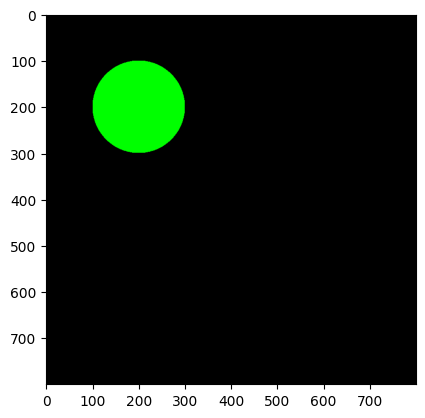

In [9]:
import numpy as np

img = np.zeros((800,800,3))

for i in range(800):
    for j in range(800):
        if (i-200)**2 + (j-200)**2 < 100**2:
            img[i,j] = [0,255,0]

import matplotlib.pyplot as plt

plt.imshow(img)

In [11]:
%%file /tmp/circle.lean

abbrev Image := Array (Array (Array UInt8))
partial def doit (N : Nat) := Id.run do
  let mut img : Image := Array.replicate N (Array.replicate N #[0, 0, 0])
  for i in [0:N] do
    for j in [0:N] do
          if ((i : Int)- N/2)^2 + ((j : Int) - N/2)^2 < (N/4)^2 -- This Int conversion sucks. But I'd have a similar problem in many other languages
          then
            img := img.modify i fun row => row.set! j #[0, 0, 255]
  return img

Writing /tmp/circle.lean


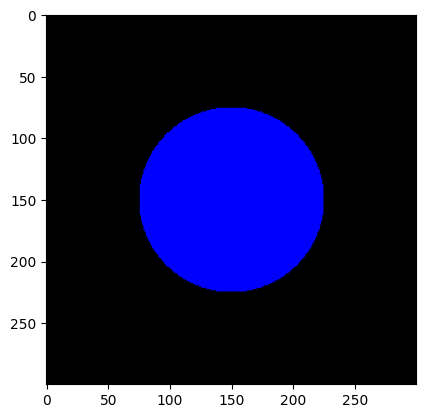

In [12]:
import leancall as lc
mod = lc.from_file("/tmp/ray.lean")
plt.imshow(mod.doit(300))

I found the lark parsing to be a bit slow (printing a giant array out is a somewhat ludicrous thing to be doing). Using `numpy.loadtxt` is quite a bit faster. I wrapped it in `leancall.numpy.parse`

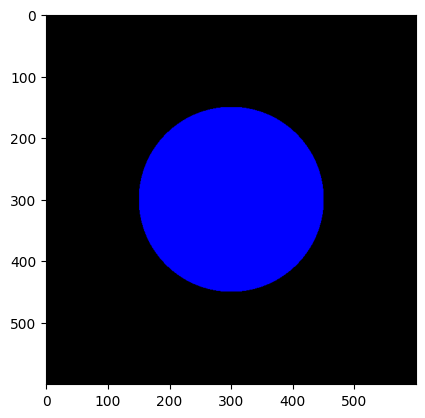

In [15]:
import leancall.numpy as lcnp
N = 600
plt.imshow(lcnp.parse(mod.doit(N, parse=None)).reshape((N,N,3)).astype(np.uint8))

This is a larger ray tracer. Again, not a paragon of anything. AI produced this largely from our python version.

In [27]:
%%file /tmp/ray.lean

abbrev Pixel := UInt8 × UInt8 × UInt8
abbrev Image : Type := Array (Array Pixel)

structure Vec3 where
  x : Float
  y : Float
  z : Float
deriving Repr, Inhabited, BEq

instance : Add Vec3 where
  add a b := ⟨a.x + b.x, a.y + b.y, a.z + b.z⟩

instance : Sub Vec3 where
  sub a b := ⟨a.x - b.x, a.y - b.y, a.z - b.z⟩


instance : HMul Float Vec3 Vec3 where
  hMul s v := ⟨s * v.x, s * v.y, s * v.z⟩

instance : HDiv Vec3 Float Vec3 where
  hDiv v s := ⟨v.x / s, v.y / s, v.z / s⟩

def dot (a b : Vec3) : Float :=
  a.x * b.x + a.y * b.y + a.z * b.z

def norm (v : Vec3) : Float :=
  Float.sqrt (dot v v)

def normalize (v : Vec3) : Vec3 :=
  let n := norm v
  if n == 0 then v else v / n

def clamp01 (x : Float) : Float :=
  if x < 0 then 0 else if x > 1 then 1 else x

def hadamard (a b : Vec3) : Vec3 :=
  ⟨a.x * b.x, a.y * b.y, a.z * b.z⟩

def floatToByte (x : Float) : UInt8 :=
  let y := clamp01 x
  UInt8.ofNat (UInt64.toNat (Float.toUInt64 (y * 255.0)))

def colorToPixel (c : Vec3) : Pixel :=
  (floatToByte c.x, floatToByte c.y, floatToByte c.z)

structure Sphere where
  center : Vec3
  radius : Float
  color : Vec3
deriving Repr, Inhabited, BEq

structure Ray where
  origin : Vec3
  direction : Vec3
deriving Repr, Inhabited, BEq

structure Light where
  position : Vec3
  color : Vec3
deriving Repr, Inhabited, BEq


def Sphere.intersect (s : Sphere) (r : Ray) : Option (Float × Vec3) :=
  let oc := r.origin - s.center
  let a := dot r.direction r.direction
  let b := 2.0 * dot oc r.direction
  let c := dot oc oc - s.radius * s.radius
  let discriminant := b * b - 4 * a * c
  if discriminant < 0 then
    none
  else
    let t1 := (-b - Float.sqrt discriminant) / (2.0 * a)
    let t2 := (-b + Float.sqrt discriminant) / (2.0 * a)
    if t1 > 0 then
      let pos := r.origin + t1 * r.direction
      let norm := (pos - s.center) / s.radius
      some (t1, norm)
    else if t2 > 0 then
      let pos := r.origin + t2 * r.direction
      let norm := (pos - s.center) / s.radius
      some (t2, norm)
    else
      none

def lights : List Light :=
  [ { position := ⟨50, 50, 0⟩, color := ⟨1, 0.1, 0.4⟩ } ]

def objects : List Sphere :=
  [ { center := ⟨0, 10, 50⟩, radius := 10, color := ⟨1, 0.1, 0.1⟩ }
  , { center := ⟨0, 0, 100⟩, radius := 10, color := ⟨0.1, 1, 0.1⟩ }
  , { center := ⟨-20, 0, 100⟩, radius := 10, color := ⟨0.1, 0.1, 1⟩ } ]

def render (N : Nat) : Image := Id.run do
  let mut img : Image := Array.replicate N (Array.replicate N (0, 0, 0))
  let half := Float.ofNat (N / 2)
  let nFloat := Float.ofNat N
  for i in [0:N] do
    for j in [0:N] do
      let dir := ⟨(Float.ofNat i - half) / nFloat, (Float.ofNat j - half) / nFloat, 1⟩
      let ray := Ray.mk ⟨0, 0, 0⟩ dir
      let mut closestT : Float := 1.0e30
      let mut pixelColor : Pixel := (135, 206, 235) -- sky color
      for obj in objects do
        match obj.intersect ray with
        | some (t, norm) =>
          if t < closestT then
            closestT := t
            let mut col : Vec3 := ⟨0, 0, 0⟩
            let hitPos := ray.origin + t * ray.direction
            for light in lights do
              let lightDir := normalize (light.position - hitPos)
              let diff := dot norm lightDir
              if diff > 0 then
                col := col + diff * (hadamard obj.color light.color)
            pixelColor := colorToPixel col
        | none => ()
      img := img.modify i fun row => row.set! j pixelColor
  img

Overwriting /tmp/ray.lean


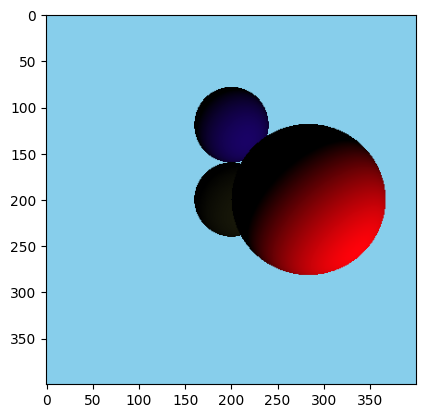

In [29]:
mod = lc.from_file("/tmp/ray.lean")
plt.imshow(mod.render(400))

# Bits and Bobbles

You pay quite an overhead to serialize and deserialize. I also added an experimental direct FFI thing. It was pretty vibe coded so I dunno.

https://www.youtube.com/watch?v=c5LOYzZx-0c 
The Best New Programming Language is a Proof Assistant by Harry Goldstein

https://www.philipzucker.com/dirty_lean/ Doing Lean Dirty: Lean as a Jupyter Notebook Replacement

https://www.philipzucker.com/lean_smt/ Using Lean like an External SMT Solver from Python


Because people are interested in 

One thing that isn't great about lean is it's library ecosystem. It's a young language still. Mathlib is remarkable, the standard library has made great strides, but there isn't much else.

I am a dirty dog. I do not like lifting little ideas out into projects of their own. I have a giant folder of files that I tinker on. I want to install garbage willy nilly and puke all over my computer. This is against best software engineering practice.

The one way I have to make this work is to just have my garvage folder have a lakefile at the top level specifying a version of lean and mathlib. I keep it updating to the latest versio nevery couple of months. Libraries get left behind.

Actually Lean stresses me out. Too many smart people working hard. What's left for little ole me?


In [ ]:
import leancall as lc
import leancall.numpy

mod = lc.from_string("def foo x := x + 1")
type(mod.foo(3))

Does leancall change how I would go about pcode?


In [2]:
%%file /tmp/app.lean
import Lean.Data.Json
structure App where
    f : String
    args : List App
deriving Repr, Inhabited, BEq, Lean.ToJson, Lean.FromJson

def idapp (a : App) : Lean.Json := Lean.toJson a

partial def is_subterm (a b : App) : Bool :=
  if a == b then
    true
  else
    match a with
    | App.mk _ args => args.any (fun arg => is_subterm arg b)



Writing /tmp/app.lean


In [3]:
import leancall as lc
import leancall.numpy
from dataclasses import dataclass
@dataclass(frozen=True)
class App:
    f: str
    args: tuple["App", ...] = ()
    def of_dict(d):
        return App(d['f'], [App.of_dict(a) for a in d['args']])


@lc.register_from_lean("App")
def _(x) -> App:
    return x
mod = lc.from_file("/tmp/app.lean")
App.of_dict(mod.idapp(App("foo", [])))
x = App("x")
y = App("y")
f = lambda x: App("f", (x,))

#mod.is_subterm(f(x), x)  # true



calllean
look at other similar solutions?
prologs?
ocaml?
clr
https://pythonnet.github.io/pythonnet/python.html

https://github.com/codyroux/simple-prolog/blob/master/SimpleProlog/Basic.lean




Overwriting /tmp/cartpole.lean


In [9]:
import numpy as np
mod = lc.from_file("/tmp/cartpole.lean")
mod.action([0.01234567, -0.00987654,  0.02345678,  0.01456789])

1

In [11]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()

print(f"Starting observation: {observation}")
# Example output: [ 0.01234567 -0.00987654  0.02345678  0.01456789]
# [cart_position, cart_velocity, pole_angle, pole_angular_velocity]

print(type(observation))
episode_over = False
total_reward = 0
try:
    while not episode_over:
        # Choose an action: 0 = push cart left, 1 = push cart right
        action = mod.action(list(observation))
        observation, reward, terminated, truncated, info = env.step(action)
        # reward: +1 for each step the pole stays upright
        # terminated: True if pole falls too far (agent failed)
        # truncated: True if we hit the time limit (500 steps)

        total_reward += reward
        episode_over = terminated or truncated
finally:
    env.close()

print(f"Episode finished! Total reward: {total_reward}")


Starting observation: [-0.04921084 -0.01602873  0.02273309 -0.01083545]
<class 'numpy.ndarray'>
Episode finished! Total reward: 500.0


# Lean interact

In [68]:
def foo1(i):
    s = 0
    for _ in range(i):
        s += i
    return s


In [69]:
%%timeit
foo1(100000)

2.18 ms ± 5.57 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
%%file /tmp/foo.lean
def foo (i : Nat) : Nat := Id.run do
    let mut s := 0
    for _ in [0:i] do
        s := s + i
    return s

Overwriting /tmp/foo.lean


In [ ]:
mod = cl.from_file("/tmp/foo.lean")

Yea, it's constant time

In [75]:
mod.foo(100000000)

10000000000000000

In [74]:
%%timeit
mod.foo(100000000)

191 μs ± 65.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from lean_interact import LeanREPLConfig, LeanServer, Command

config = LeanREPLConfig(verbose=True) # download and build Lean REPL
server = LeanServer(config) # start Lean REPL
server.run(Command(cmd="theorem ex (n : Nat) : n = 5 → n = 5 := id"))


In [14]:
server.run(Command(cmd="def mysucc x := x + 1", env=0))

CommandResponse(env=1)

In [15]:
server.run(Command(cmd="#eval mysucc 41", env=1))

CommandResponse(env=2, messages=[Message(start_pos=Pos(line=1, column=0), severity='info', data='42', end_pos=Pos(line=1, column=5))])

In [ ]:
"""
def to_lean(x : object) -> str:
    if isinstance(x, int):
        return str(x)
    elif isinstance(x, bool):
        return "true" if x else "false"
    elif isinstance(x, str):
        return f'"{x}"'
    elif isinstance(x, list):
        return "[" + ", ".join(map(to_lean, x)) + "]"
    elif isinstance(x, tuple):
        return "(" + ", ".join(map(to_lean, x)) + ")"
    elif isinstance(x, float):
        return str(x)
    # dict -> json or hashmap?
    else:
        raise Exception(f"Cannot convert {x} to Lean")
"""

Could have lean reach into python process and directly access memory for numpy / buffers
That'd be nasssssty.



In [ ]:
from lean_interact import LeanREPLConfig, LeanServer, Command
from functools import singledispatch

config = LeanREPLConfig(verbose=True) # download and build Lean REPL
server = LeanServer(config) # start Lean REPL

@singledispatch
def to_lean(x : object) -> str:
    raise Exception(f"Cannot convert {x} to Lean")
@to_lean.register
def _(x : int) -> str:
    return str(x)
@to_lean.register
def _(x : bool) -> str:
    return "true" if x else "false"
@to_lean.register
def _(x : str) -> str:
    return f'"{x}"'
@to_lean.register
def _(x : float) -> str:
    return str(x)
@to_lean.register(list)
def _(x : list) -> str:
    return "[" + ", ".join(map(to_lean, x)) + "]"
@to_lean.register(tuple)
def _(x : tuple) -> str:
    return "(" + ", ".join(map(to_lean, x)) + ")"

def from_lean(x : str, typ : str) -> object:
    if typ == "Nat" or typ == "Int":
        return int(x)
    elif typ == "Bool":
        assert x in ["true", "false"]
        return x == "true"
    elif typ == "String":
        return x.strip('"')
    elif typ == "Float":
        return float(x)
    elif typ == "Unit":
        assert x == "()"
        return ()
    elif typ.startswith('Option '):
        if x == "none":
            return None
        elif x.startswith("some "):
            inner_typ = typ[len('Option '):]
            return from_lean(x[len("some "):], inner_typ)
    else:
        # hail mary
        # may work for lists and tuples of simple elements
        return eval(x)
    
class LeanFun():
    def __init__(self, code, env=None):
        codesplit = code.split()
        assert codesplit[0] == "def"
        self.name = codesplit[1]
        self.code = code
        res = server.run(Command(cmd=code, env=env))
        if hasattr(res, "messages") and len(res.messages) > 0:
            for message in res.messages:
                if message.severity == "error":
                    raise Exception(message.data)
        self.env = res.env
        # get return type for deserialization
        res = server.run(Command(cmd=f"#check {self.name}", env=self.env))
        self.res_type = res.messages[0].data.split(":")[-1].strip()

    @classmethod
    def from_string(cls, code : str, env=None):
        ...

    def from_file(cls, filename : str, names : list[str], env=None):
        # load from file
        # return list of LeanFun objects
        ...

    def __call__(self, *args, **kwargs):
        res = server.run(Command(cmd=f"#eval {self.name} " + " ".join(map(to_lean, args)), env=self.env))
        assert len(res.messages) == 1
        message = res.messages[0]
        if message.severity == "info":
            return from_lean(message.data, self.res_type)
        else:
            raise Exception(message.data)
        
f = LeanFun("def mysucc (x y : Int) (s : String) (p : Nat × Nat) (r : List Int) (f : Float) := (f + 1.3, x + y + s.length + p.fst + r[0]!) |> some")
print(f.res_type)
f(1,2, "foo", (4,5), [1,2,3], 7.4)


Lake version 5.0.0-src+d8204c9 (Lean version 4.26.0)
Build completed successfully (26 jobs).
Option (Float × Int)


(8.7, 11)

In [74]:
%%prun -s cumulative
for i in range(1000):
    f(1,2, "foo", (4,5))

         216676 function calls (202767 primitive calls) in 0.260 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1000    0.004    0.000    0.263    0.000 2346713141.py:90(__call__)
        1    0.001    0.001    0.259    0.259 <string>:1(<module>)
     1000    0.004    0.000    0.247    0.000 server.py:327(run)
     1000    0.003    0.000    0.211    0.000 server.py:242(run_dict)
     1000    0.003    0.000    0.189    0.000 server.py:173(_execute_cmd_in_repl)
     1000    0.002    0.000    0.173    0.000 threading.py:1115(join)
     1000    0.002    0.000    0.150    0.000 threading.py:1153(_wait_for_tstate_lock)
     1000    0.012    0.000    0.129    0.000 threading.py:1016(_bootstrap)
     1000    0.001    0.000    0.117    0.000 threading.py:1056(_bootstrap_inner)
     1000    0.003    0.000    0.114    0.000 ipkernel.py:744(run_closure)
     1000    0.001    0.000    0.086    0.000 threading.py:999(run)
     10

In [63]:
def mysucc(x, y):
    return x + y

In [64]:
%%timeit
mysucc(41, 43)

24 ns ± 0.404 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


https://github.com/leanprover-community/repl


Hmm. Ingest response via microlean?
Use simp

l.lean_simp



In [4]:
from kdrag.all import *
kd.lean("1 + 1.0")
import kdrag.printers.lean as plean

plean.of_expr

<function kdrag.printers.lean.of_expr(e: z3.z3.ExprRef)>